In [1]:
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
from IPython.display import IFrame

In [2]:
# Load the Excel files into Pandas DataFrames
gis_weather_station = pd.read_excel('gis_weatherstation_shape_2024_10_04.xlsx', engine='openpyxl')
station_summary_snapshot = pd.read_excel('src_wings_meteorology_station_summary_snapshot_2023_08_02.xlsx', engine='openpyxl')
windspeed_snapshot = pd.read_excel('src_wings_meteorology_windspeed_snapshot_2023_08_02.xlsx', engine='openpyxl')

In [3]:
gis_weather_station.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,elevation,twinguid,hftd,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,2024-10-04
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,2513,NaN,3,N,Y,NaN,{82759049-437B-4A5C-8796-10C8D7098C5B},POINT (1667010.27856 12088881.1767),4431,2024-10-04
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,1822,NaN,3,N,Y,NaN,{6A3A6DAD-6CD1-43B7-A0FE-72A52A46A4F7},POINT (1703876.2967 11989778.75946),4431,2024-10-04
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,1533,NaN,3,N,Y,NaN,{AD1AEA81-BC74-4954-8D25-421C79F40D88},POINT (1646528.56915 12083236.45575),4431,2024-10-04
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,448,NaN,1,N,N,NaN,{1294A90A-9558-458E-8EA5-9D15B2A16D8D},POINT (1619955.10724 11883209.4286),4431,2024-10-04


In [4]:
station_summary_snapshot.head()

,station,vri,alert,max_gust,99th,95th,snapshot_date
0,AMO,H,35,40,32,24,2023-08-02
1,ANE,M,35,43,32,25,2023-08-02
2,ARH,L,40,46,40,31,2023-08-02
3,AVO,H,35,43,29,24,2023-08-02
4,AVY,L,45,62,53,40,2023-08-02


In [5]:
windspeed_snapshot.head()

,date,wind_speed,station,snapshot_date
0,2012-09-14,19.0,AMO,2023-08-02
1,2012-09-15,20.0,AMO,2023-08-02
2,2012-10-14,16.0,AMO,2023-08-02
3,2012-10-26,23.0,AMO,2023-08-02
4,2012-10-27,15.0,AMO,2023-08-02


In [6]:
print(f"gis weather station shape: {gis_weather_station.shape}")
print(f"station summary shape: {station_summary_snapshot.shape}")
print(f"windspeed snapshot shape: {windspeed_snapshot.shape}")

gis weather station shape: (223, 27)
station summary shape: (216, 7)
windspeed snapshot shape: (38664, 4)


In [7]:
#Check null data for gis weather station
gis_weather_station.isna().sum()

objectid                0
weatherstationcode      0
weatherstationname      0
scadartuid              1
structureid             5
nwszone                 0
district                3
thomasbrospagegrid      2
constructionstatus      0
creationuser            0
datecreated             0
datemodified            4
lastuser                4
structureguid           6
symbolrotation          0
latitude                0
longitude               0
elevation               0
twinguid              223
hftd                    0
zone1idc                0
hftdidc                 0
gdb_geomattr_data     223
globalid                0
shape                   0
shape_srid              0
snapshot_date           0
dtype: int64

In [8]:
#Check null data for station summary
station_summary_snapshot.isna().sum()

station           0
vri              10
alert             0
max_gust          0
99th              0
95th              0
snapshot_date     0
dtype: int64

In [9]:
#Check null data for wind speed summary
windspeed_snapshot.isna().sum()

date                0
wind_speed       8724
station             0
snapshot_date       0
dtype: int64

In [10]:
station_summary_snapshot['vri'].unique().tolist()

['H', 'M', 'L', nan]

In [11]:
station_stats = station_summary_snapshot.drop(['station', 'snapshot_date'], axis=1)[station_summary_snapshot['vri'].notna()].groupby('vri').agg(['mean', 'median'])
station_stats.index = pd.Categorical(station_stats.index, categories=['L', 'M', 'H'], ordered=True)
station_stats = station_stats.sort_index()
station_stats

alert          max_gust              99th              95th       
        mean median       mean median       mean median       mean median
L  40.797619   42.5  53.892857   53.5  43.238095   43.5  33.880952   34.0
M  38.968085   37.5  49.468085   50.0  39.191489   39.5  30.968085   31.0
H  35.357143   35.0  44.571429   43.5  35.250000   34.5  27.928571   27.5

In [12]:
def impute_vri(dataset, descriptive_data, column, stats):
    ser = descriptive_data[column][stats]
    low_threshold = (ser.loc['L'] + ser.loc['M']) / 2
    medium_threshold = (ser.loc['M'] + ser.loc['H']) / 2
    
    if dataset > low_threshold:
        return 'L'
    elif dataset > medium_threshold:
        return 'M'
    else:
        return 'H'
    

station_summary_snapshot['vri'] = station_summary_snapshot.apply(lambda row: impute_vri(row['alert'], station_stats, 'alert', 'mean') 
                     if pd.isnull(row['vri']) else row['vri'], axis=1)

station_summary_snapshot['vri'].isna().sum()

0

In [13]:
windspeed_snapshot[windspeed_snapshot['wind_speed'].isna()].groupby('station').count().sort_values('date', ascending=True)

,date,wind_speed,snapshot_date
station,,,
WYN,1,0,1
SPV,1,0,1
MLG,1,0,1
MGD,1,0,1
LFR,1,0,1
...,...,...,...
BOB,134,0,134
GAV,134,0,134
DAM,136,0,136


In [14]:
windspeed_snapshot.sort_values(by='wind_speed', ascending=False)

,date,wind_speed,station,snapshot_date
2180,2013-12-14,611.0,BOC,2023-08-02
30293,2014-04-30,101.0,SIL,2023-08-02
30394,2020-12-03,94.0,SIL,2023-08-02
13732,2019-12-17,91.0,HHC,2023-08-02
30350,2018-01-28,89.0,SIL,2023-08-02
...,...,...,...,...
37886,2018-12-31,NaN,WST,2023-08-02
38000,2014-11-16,NaN,WSY,2023-08-02
38001,2014-11-17,NaN,WSY,2023-08-02
38002,2014-11-18,NaN,WSY,2023-08-02


In [15]:
#Dropping outlier data
windspeed_snapshot = windspeed_snapshot[(windspeed_snapshot['wind_speed'] < max(windspeed_snapshot['wind_speed']))]
windspeed_snapshot.sort_values(by='wind_speed', ascending=False)

,date,wind_speed,station,snapshot_date
30293,2014-04-30,101.0,SIL,2023-08-02
30394,2020-12-03,94.0,SIL,2023-08-02
13732,2019-12-17,91.0,HHC,2023-08-02
30350,2018-01-28,89.0,SIL,2023-08-02
30343,2017-12-07,88.0,SIL,2023-08-02
...,...,...,...,...
10511,2019-12-20,6.0,ECJ,2023-08-02
3757,2022-12-24,6.0,CAP,2023-08-02
963,2015-11-23,6.0,BFD,2023-08-02
28429,2020-12-23,6.0,RIO,2023-08-02


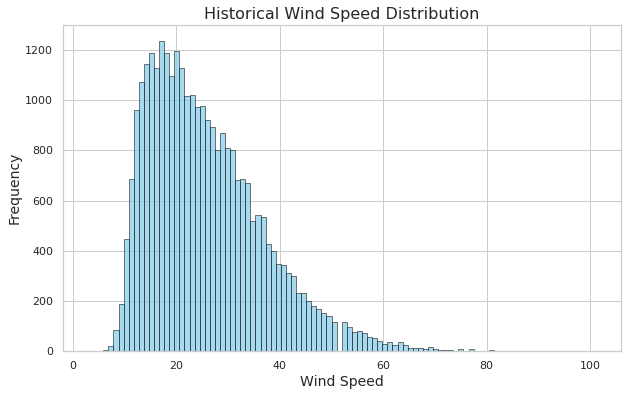

Wind Speed data is Right Skewed


In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(windspeed_snapshot['wind_speed'].dropna(), bins=100, kde=False, color='skyblue', edgecolor='black')

plt.title('Historical Wind Speed Distribution', fontsize=16)
plt.xlabel('Wind Speed', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()
print('Wind Speed data is Right Skewed')

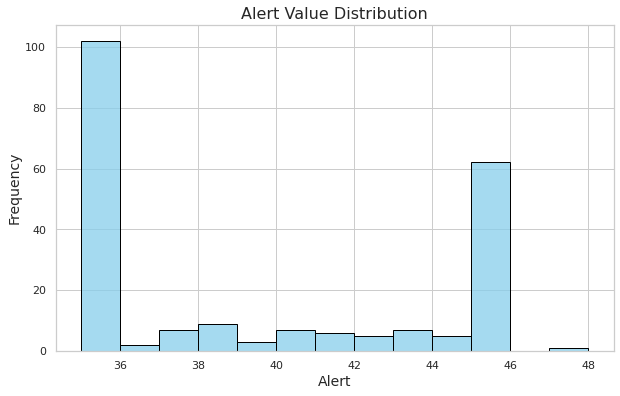

Alert Value is Bi-Modal


In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(station_summary_snapshot['alert'].dropna(), 
             bins=(max(station_summary_snapshot['alert']) - min(station_summary_snapshot['alert'])), 
             kde=False, color='skyblue', edgecolor='black')

plt.title('Alert Value Distribution', fontsize=16)
plt.xlabel('Alert', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()
print('Alert Value is Bi-Modal')

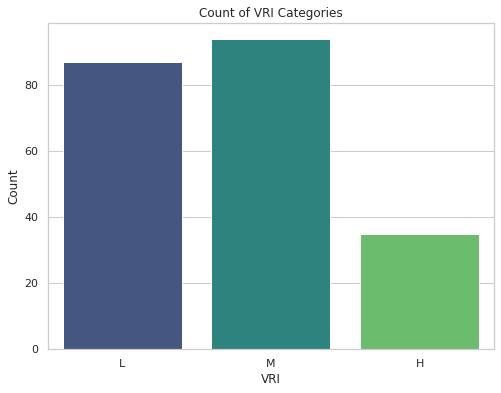

In [18]:
vri_counts = station_summary_snapshot['vri'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=vri_counts.index, y=vri_counts.values, palette='viridis', order=['L', 'M', 'H'])
plt.title('Count of VRI Categories')
plt.xlabel('VRI')
plt.ylabel('Count')
plt.show()

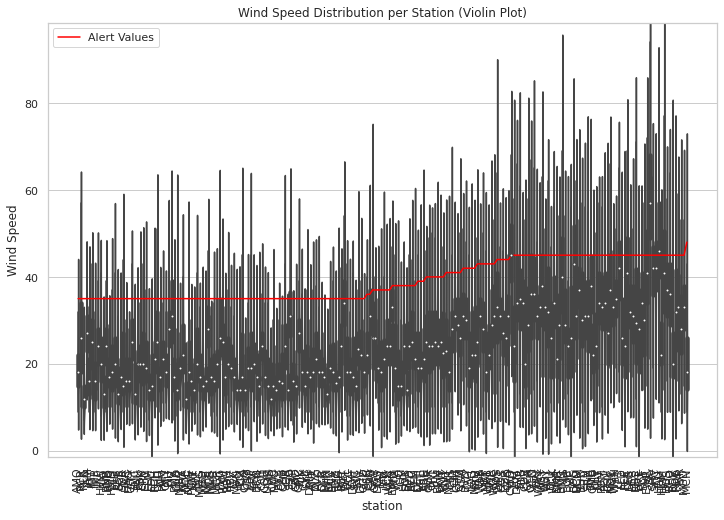

In [19]:
plt.figure(figsize=(12, 8))

#Sort station by ascending alert values
station_summary_sorted = station_summary_snapshot.sort_values(by='alert')
sorted_stations = station_summary_sorted['station'].values

# Set the x-axis order based on the sorted stations
sns.violinplot(x='station', y='wind_speed', data=windspeed_snapshot, order=sorted_stations)

# Plot the alert values
plt.plot(sorted_stations, station_summary_sorted['alert'].values, 
         marker='', color='red', label='Alert Values')

plt.xticks(rotation=90)
plt.ylabel('Wind Speed')
plt.title('Wind Speed Distribution per Station (Violin Plot)')
plt.legend()
plt.show()

In [20]:
merged_weather_station = gis_weather_station.merge(station_summary_snapshot, left_on='weatherstationcode', right_on='station').drop(columns=['station'])
merged_weather_station.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,globalid,shape,shape_srid,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,2024-10-04,M,35,39,33,25,2023-08-02
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,{82759049-437B-4A5C-8796-10C8D7098C5B},POINT (1667010.27856 12088881.1767),4431,2024-10-04,M,45,73,50,37,2023-08-02
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,{6A3A6DAD-6CD1-43B7-A0FE-72A52A46A4F7},POINT (1703876.2967 11989778.75946),4431,2024-10-04,M,41,64,41,33,2023-08-02
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,{AD1AEA81-BC74-4954-8D25-421C79F40D88},POINT (1646528.56915 12083236.45575),4431,2024-10-04,L,45,64,47,33,2023-08-02
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,{1294A90A-9558-458E-8EA5-9D15B2A16D8D},POINT (1619955.10724 11883209.4286),4431,2024-10-04,L,35,30,25,19,2023-08-02


In [21]:
# Create a Folium map centered around San Diego
san_diego_map = folium.Map(location=[32.7157, -117.1611], zoom_start=10)  # San Diego's latitude and longitude

# Add markers to the map using the existing latitude and longitude columns
for _, row in merged_weather_station.iterrows():
    tooltip_text = f"""
    <strong>{row['weatherstationname']}</strong><br>
    Station Code: {row['weatherstationcode']}<br>
    VRI Value: {row['vri']}<br>
    Alert: {row['alert']}<br>
    """
    
    if row['vri'] == 'L':
        icon_color = 'lightred'
    elif row['vri'] == 'M':
        icon_color = 'orange'
    else:
        icon_color = 'red'
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color=icon_color, icon="info-sign"),
        popup=tooltip_text,
        tooltip=tooltip_text
    ).add_to(san_diego_map)

# Save the map
san_diego_map.save('san_diego_weather_stations_map.html')  # Save the map to an HTML file

# Display the map
IFrame('san_diego_weather_stations_map.html', width=800, height=500)

In [22]:
merged_station_wind_speed = merged_weather_station.merge(windspeed_snapshot, left_on='weatherstationcode', right_on='station').drop(columns=['station'])
merged_station_wind_speed.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y,date,wind_speed,snapshot_date
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2012-12-10,11.0,2023-08-02
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2012-12-19,16.0,2023-08-02
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2012-12-20,17.0,2023-08-02
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2012-12-25,13.0,2023-08-02
4,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2013-04-18,28.0,2023-08-02


<Figure size 864x576 with 0 Axes>

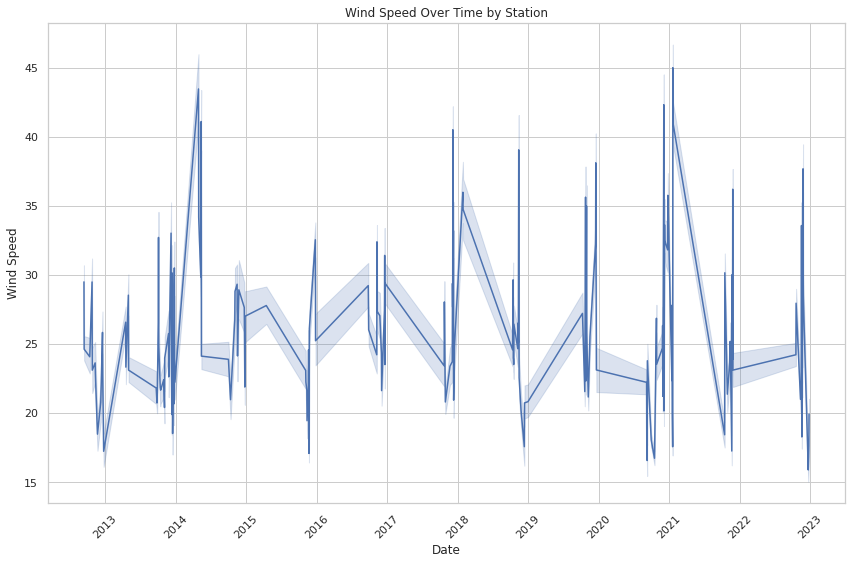

In [23]:
plt.figure(figsize=(12, 8))

merged_station_wind_speed['date'] = pd.to_datetime(merged_station_wind_speed['date'])

plt.figure(figsize=(12, 8))

# Plotting the wind speed over time
sns.lineplot(x='date', y='wind_speed', data=merged_station_wind_speed)

plt.title('Wind Speed Over Time by Station')
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.xticks(rotation=45)

# Set x-axis major locator to year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set minor locator to show ticks for each month
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Show grid lines
plt.grid(visible=True)

# Show the plot
plt.tight_layout()
plt.show()